/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25, Loss: 0.5970, Validation Loss: 0.2764, Training Accuracy: 0.7919, Validation Accuracy: 0.8985
Epoch 2/25, Loss: 0.3566, Validation Loss: 0.3742, Training Accuracy: 0.8822, Validation Accuracy: 0.8889
Epoch 3/25, Loss: 0.3047, Validation Loss: 0.2174, Training Accuracy: 0.9059, Validation Accuracy: 0.9213
Epoch 4/25, Loss: 0.2185, Validation Loss: 0.1892, Training Accuracy: 0.9322, Validation Accuracy: 0.9318
Epoch 5/25, Loss: 0.2148, Validation Loss: 0.1460, Training Accuracy: 0.9343, Validation Accuracy: 0.9484
Epoch 6/25, Loss: 0.1868, Validation Loss: 0.1464, Training Accuracy: 0.9416, Validation Accuracy: 0.9589
Epoch 7/25, Loss: 0.1760, Validation Loss: 0.2033, Training Accuracy: 0.9440, Validation Accuracy: 0.9466
Epoch 8/25, Loss: 0.1572, Validation Loss: 0.0986, Training Accuracy: 0.9516, Validation Accuracy: 0.9711
Epoch 9/25, Loss: 0.1214, Validation Loss: 0.2488, Training Accuracy: 0.9617, Validation Accuracy: 0.9248
Epoch 10/25, Loss: 0.1758, Validation Loss: 0.

/tmp/ipykernel_30/4252391780.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Validation Accuracy: 0.9703
Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.97      0.98       264
  meningioma       0.96      0.95      0.96       282
     notumor       0.97      0.99      0.98       309
   pituitary       0.97      0.97      0.97       288

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143



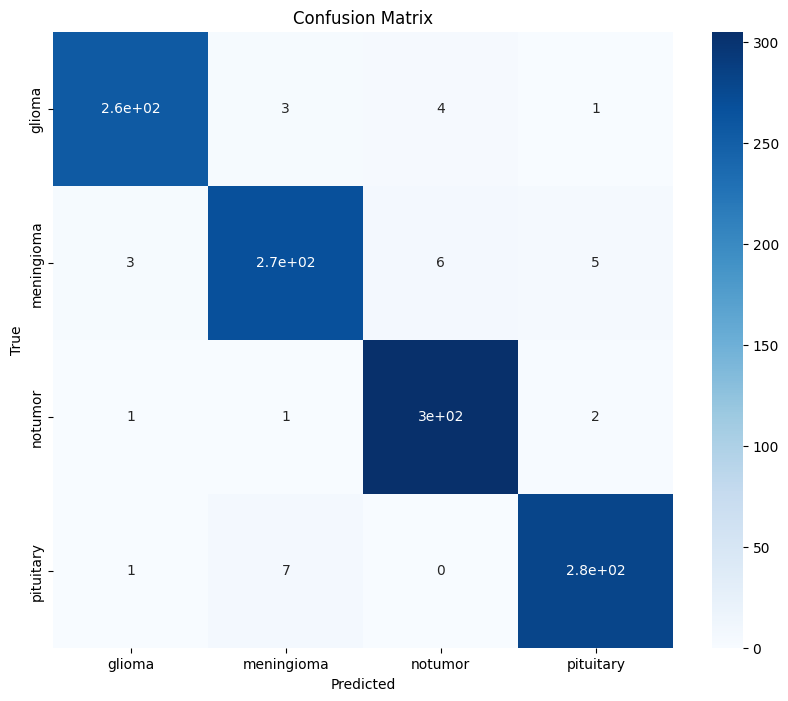

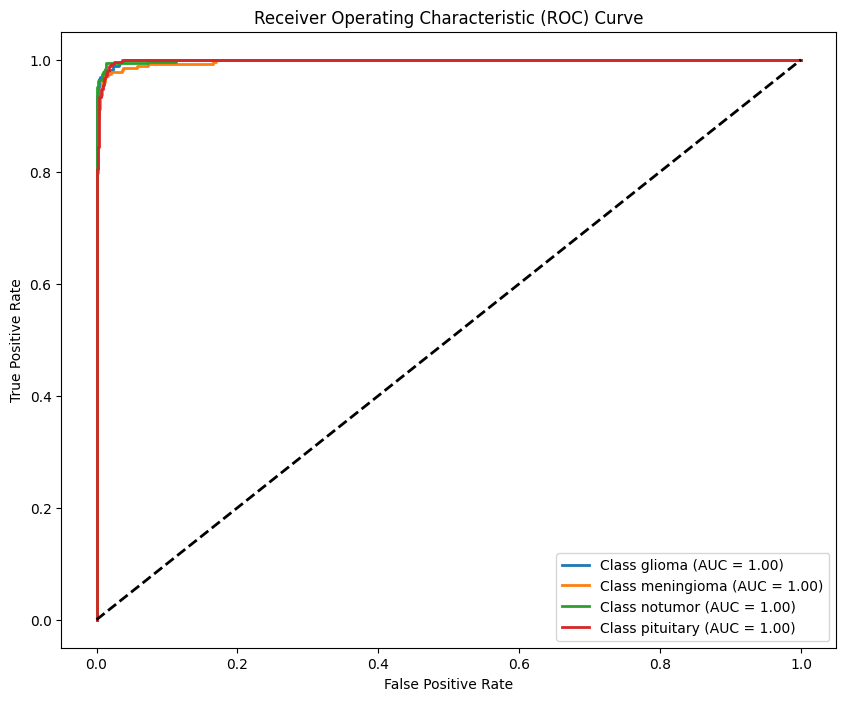

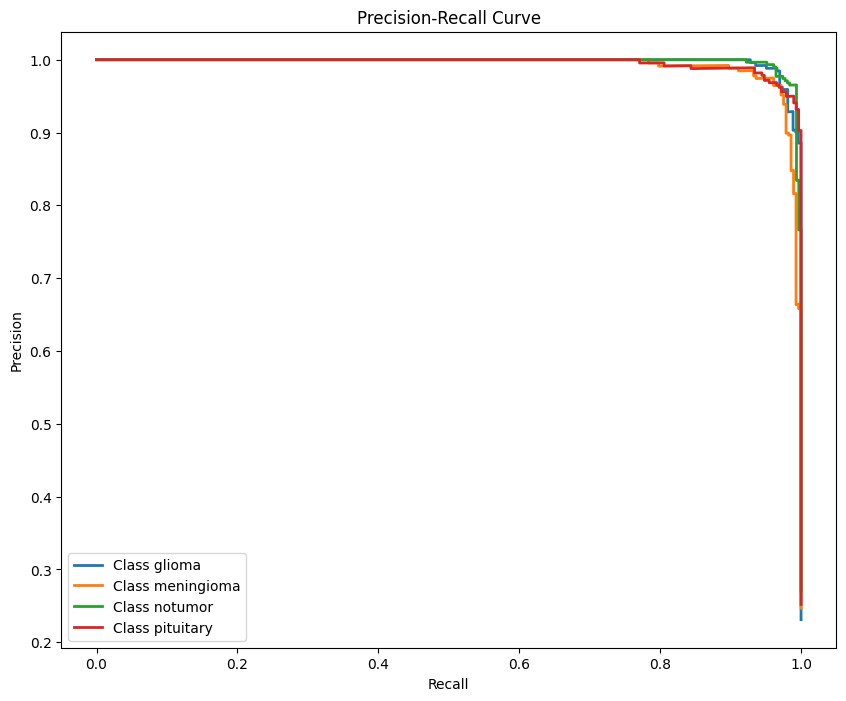

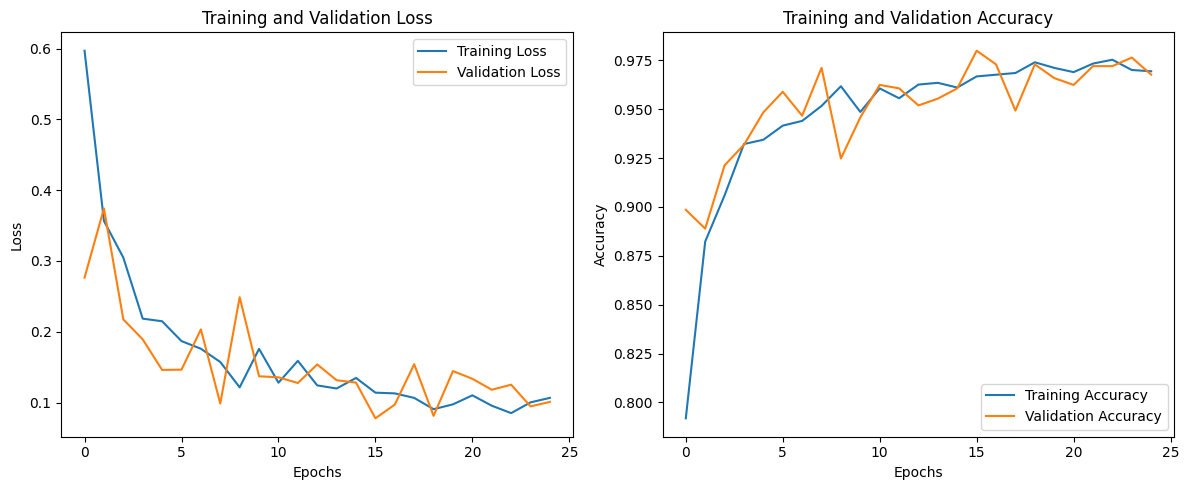

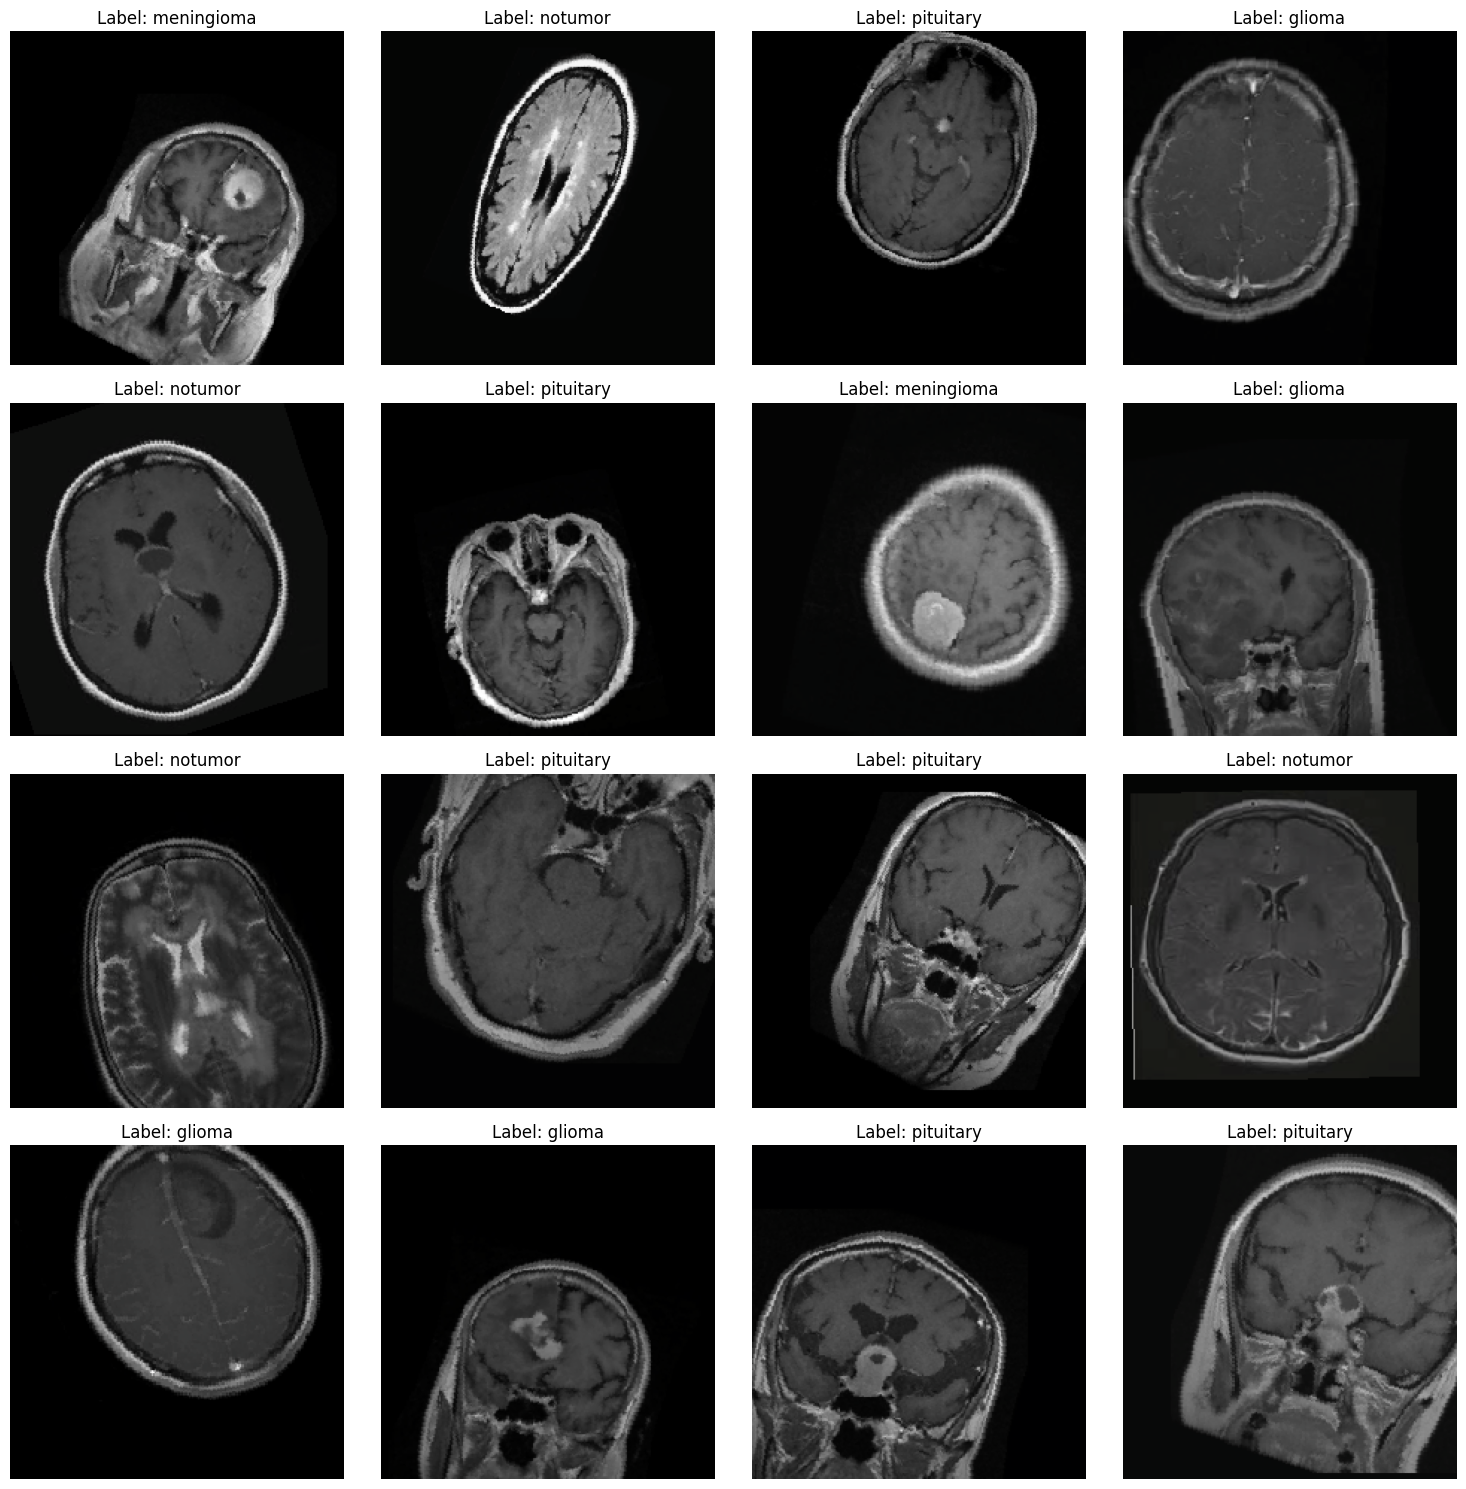

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b0
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with augmented data
train_dataset = ImageFolder('/kaggle/input/brain-tumor/Training', transform=data_transforms)
val_dataset = ImageFolder('/kaggle/input/brain-tumor/Testing', transform=data_transforms)

# Split train dataset for training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load EfficientNetB0 model
model = efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(train_dataset.dataset.classes))
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
best_accuracy = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

print('Training complete. Best Validation Accuracy: {:.4f}'.format(best_accuracy))

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluation on validation set
correct = 0
total = 0
all_labels = []
all_preds = []
all_probs = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.4f}')

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.dataset.classes))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
all_labels_bin = np.array([[1 if label == i else 0 for i in range(len(train_dataset.dataset.classes))] for label in all_labels])
all_probs = np.array(all_probs)
plt.figure(figsize=(10, 8))
for i in range(len(train_dataset.dataset.classes)):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {train_dataset.dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(len(train_dataset.dataset.classes)):
    precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {train_dataset.dataset.classes[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Training and Validation Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


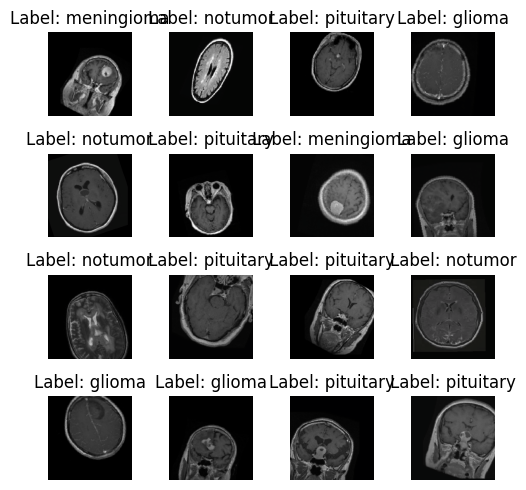

In [13]:
# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(5, 5))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()